In [1]:
from pettingzoo.classic import connect_four_v3
import random
import numpy as np
from tqdm import tqdm
import time
import matplotlib.pyplot as plt

import torch
from torch import nn

# Set up NN

In [2]:
class NeuralNetwork(nn.Module):
    def __init__(self, input_size=6 * 7 * 2, output_size=7):
        super(NeuralNetwork, self).__init__()
        self.input_size = input_size
        self.output_size = output_size
        self.stack = nn.Sequential(
            nn.Linear(in_features=self.input_size, out_features=self.input_size**2),
            nn.PReLU(),
            nn.Linear(self.input_size**2, self.output_size),
        )

    def forward(self, x):
        logits = self.stack(x)
        return logits

# Set up agent

In [3]:
class Player:
    def __init__(self, get_action) -> None:
        self.get_action = get_action

# Set up training

In [12]:
class Qlearning:
    def __init__(
        self, exploration_factor=0.5, exploration_factor_decay_steps=5000, exploration_factor_decay_rate=0.5, discount_factor=0.7, learning_rate=0.1, model=None
    ) -> None:
        self.exploration_factor = exploration_factor
        self.exploration_factor_decay_steps = exploration_factor_decay_steps
        self.exploration_factor_decay_rate = exploration_factor_decay_rate
        self.discount_factor = discount_factor
        self.learning_rate = learning_rate
        self.q_table = {}
        self.model = model
        
    def initialize_stats(self):
        self.stats = {
            "winner": [], 
            "nb_moves_to_win": []
        }
    
    def update_stats(self, winner, nb_moves_to_win):
        self.stats["winner"].append(winner)
        self.stats["nb_moves_to_win"].append(nb_moves_to_win)

    def training(self, n_training_game=1000, batch_size=100):
        self.env = connect_four_v3.env()
        self.initialize_stats()
        self.loss = nn.MSELoss()
        self.optimizer = torch.optim.Adam(self.model.parameters())
        for _ in tqdm(range(n_training_game // batch_size)):
            inputs = []
            outputs = []
            games = 0
            while games != batch_size:
                self.env.reset()
                self.agents = {
                    0: {
                        "name": "player_0",
                        "last_state": None,
                        "current_state": None,
                        "reward": 0,
                        "action": None,
                    },
                    1: {
                        "name": "player_1",
                        "last_state": None,
                        "current_state": None,
                        "reward": 0,
                        "action": None,
                    },
                }
                end = False

                i = 0
                while end is False:
                    current_agent = self.agents[i % 2]["name"]
                    self.env.agent_selection = current_agent

                    state = self.env.observe(current_agent)

                    self.agents[i % 2]["last_state"] = state["observation"].flatten()

                    y = self.model(torch.Tensor(state["observation"].flatten()))

                    if random.uniform(0, 1) < self.exploration_factor:
                        action = self.env.action_space(current_agent).sample(state["action_mask"])
                    else:
                        possible = [
                            y[i].item() if state["action_mask"][i] != 0 else -np.inf
                            for i in range(7)
                        ]
                        action = np.argmax(possible)

                    self.env.step(action)
                    state, reward, termination, truncation, info = self.env.last()

                    self.agents[i % 2]["reward"] = reward

                    self.agents[i % 2]["current_state"] = state["observation"].flatten()

                    y = y.detach().numpy()

                    end = termination or truncation

                    self.agents[i % 2]["action"] = y

                    if end:
                        games += 1
                        if self.agents[i % 2]["reward"] == 1:
                            self.agents[(i + 1) % 2]["reward"] = -1

                        for j in [0, 1]:
                            try:
                                Q_sa = torch.max(
                                    self.model(torch.Tensor(self.agents[j]["current_state"]))
                                ).item()
                                self.agents[j % 2]["action"][action] = (
                                    reward + self.discount_factor * Q_sa
                                )

                                inputs.append(self.agents[j % 2]["last_state"])
                                outputs.append(self.agents[j % 2]["action"])

                            except:
                                pass
                            
                        # Update stats
                        self.update_stats(winner=current_agent, nb_moves_to_win=i)
                        
                    i += 1
                    
                # exponential decay
                self.exploration_factor *= self.exploration_factor_decay_rate ** (1 / self.exploration_factor_decay_steps)

                self.env.close()
            inputs = torch.Tensor(np.array(inputs))
            outputs = torch.Tensor(np.array(outputs)).reshape(
                inputs.shape[0], 1, self.model.output_size
            )

            pred = self.model(inputs)
            loss = self.loss(pred.unsqueeze(1), outputs)

            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()

    def play(self):
        self.env = connect_four_v3.env(render_mode="human")
        self.env.reset()
        self.agents = {
            0: {"name": "player_0", "last_state": None, "current_state": None, "reward": 0},
            1: {"name": "player_1", "last_state": None, "current_state": None, "reward": 0},
        }
        end = False
        i = 0
        while end is False:
            current_agent = self.agents[i % 2]["name"]
            self.env.agent_selection = current_agent

            state = self.env.observe(current_agent)

            y = self.model(torch.Tensor(state["observation"].flatten()))

            possible = [y[i].item() if state["action_mask"][i] != 0 else -np.inf for i in range(7)]
            action = np.argmax(possible)

            self.env.step(action)
            state, reward, termination, truncation, info = self.env.last()

            y = y.detach().numpy()

            end = termination or truncation

            i += 1
            time.sleep(0.3)
            
        time.sleep(3)
        self.env.close()
        
    def plot_training_stats(self):
        
        # initial stats
        winner = np.array(self.stats["winner"])
        nb_moves_to_win = np.array(self.stats["nb_moves_to_win"])
        mobile_mean_nb_moves_to_win = np.convolve(nb_moves_to_win, np.ones(10), 'valid') / 10
        N = len(winner)
        
        # compute advanced stats
        player_0_is_winner = (winner == "player_0")
        percentage_win_player_0 = np.zeros(N)
        for idx in range(N):
            percentage_win_player_0[idx] = np.sum(player_0_is_winner[:idx+1])/(idx+1)
        
        # plot stats
        fig, axs = plt.subplots(3, 1, figsize=(10, 15))
        
        axs[0].set_title("Winning percentage for player 0 (red)")
        axs[0].plot(range(N), percentage_win_player_0, color='red')
        axs[0].axhline(y=np.mean(percentage_win_player_0),color='red',linestyle='--')
        axs[0].axhline(y=0.5,color='gray',linestyle='--')
        axs[0].set_xlabel('Epoch')
        
        axs[1].set_title("Number of moves needed to win")
        axs[1].plot(range(len(mobile_mean_nb_moves_to_win)), mobile_mean_nb_moves_to_win, color='grey')
        axs[1].set_xlabel('Epoch')
        
        axs[2].set_title("Histogram of number of moves needed to win")
        axs[2].hist(nb_moves_to_win, color='grey')
        axs[2].set_xlabel('Epoch')

In [8]:
Q = Qlearning(model=NeuralNetwork())

In [9]:
Q.training(n_training_game=10000, batch_size=64)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 156/156 [01:42<00:00,  1.52it/s]


# Analyze training

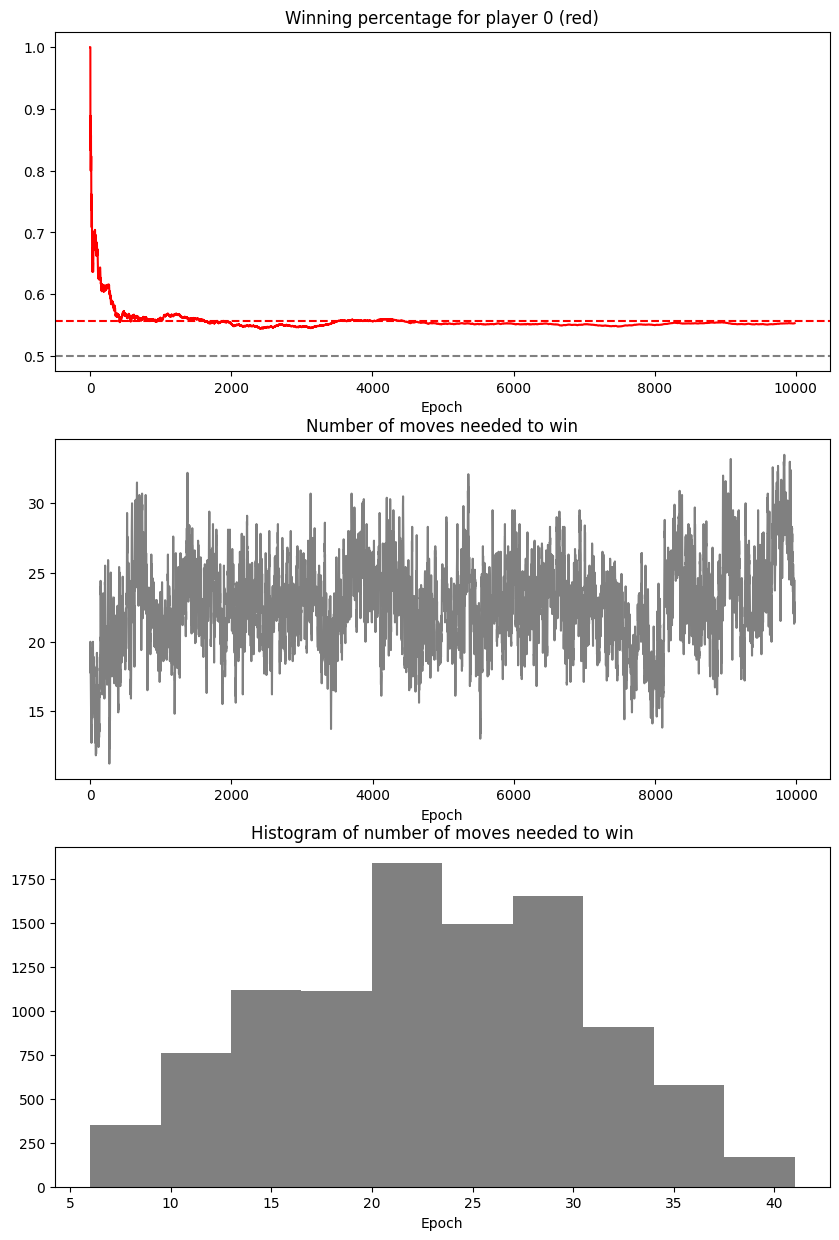

In [10]:
Q.plot_training_stats()
plt.show()

# Look at one game

In [13]:
Q.play()

In [ ]:
player = Player(get_action=lambda state: Q.get_action(state))